In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS

In [2]:
df=pd.read_csv('CNN_Articels_clean.csv')

In [3]:
df.drop('Index',axis=1,inplace=True)

In [4]:
df.head(3)

,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."


In [5]:
df['Category'].value_counts()

sport            2176
news             1611
business          104
politics           75
entertainment      58
health             52
Name: Category, dtype: int64

## Building a category wise WordCloud

In [6]:
def generate_wordcloud(category):
    import pandas as pd
    import numpy as np
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    cat_df=df[df['Category']==category]
    cat_txt= " ".join(cat_df['Article text'])
    stop_words = ['said','now','came','life'] + list(STOPWORDS)
    wc = WordCloud(max_words = 200,regexp = "[A-Za-z']+", width = 800, height = 400, stopwords =stop_words, random_state = 1234)
    plt.figure(figsize = (15,10))
    plt.imshow(wc.generate_from_text(cat_txt))
    plt.show()


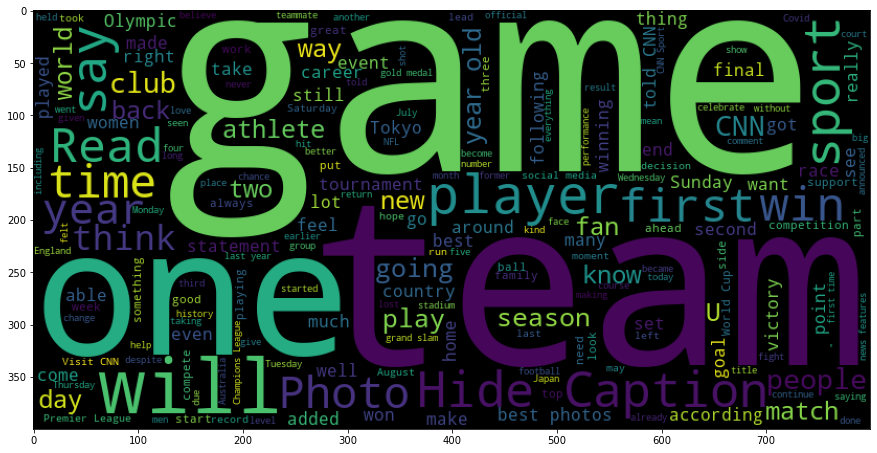

In [7]:
generate_wordcloud('sport')

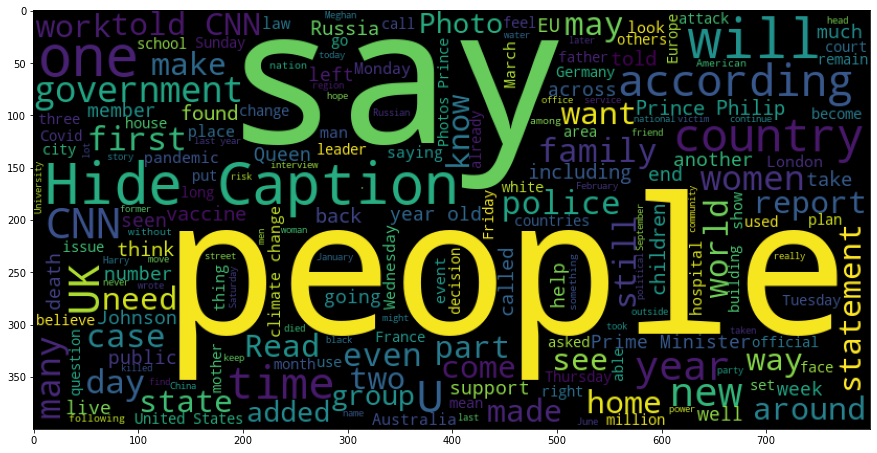

In [8]:
generate_wordcloud('news')

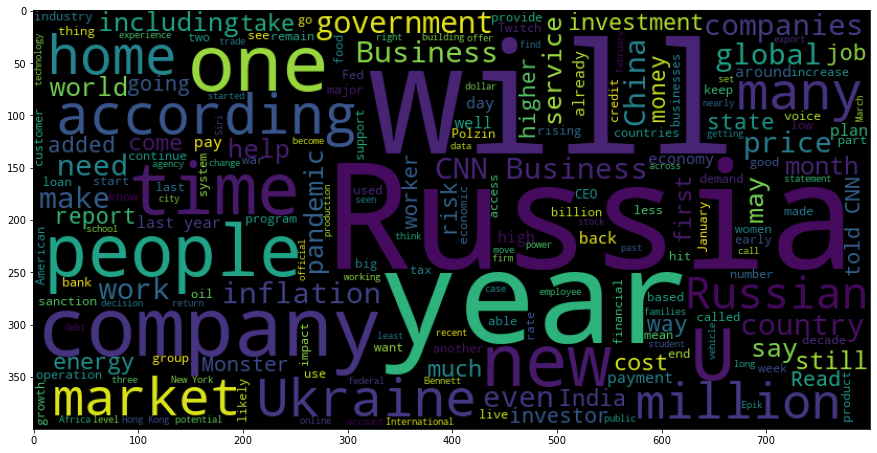

In [9]:
generate_wordcloud('business')

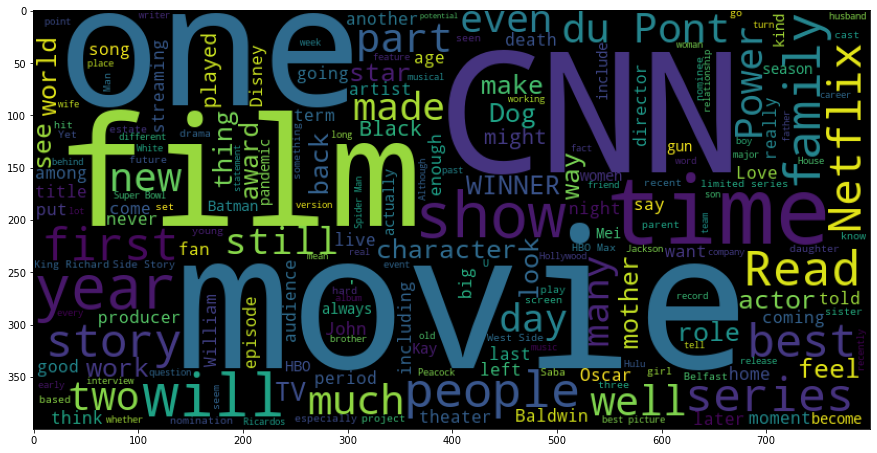

In [10]:
generate_wordcloud('entertainment')

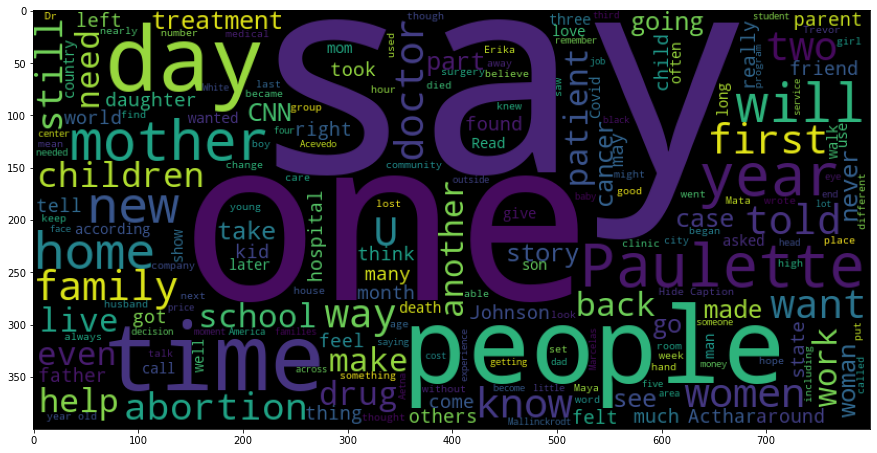

In [11]:
generate_wordcloud('health')

## Generating the top 5 related word to the enter word using LSA

In [12]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
def func(file, query_word, no_of_similarity_word):
    df=pd.read_csv(file)
    tfidf= TfidfVectorizer(stop_words=STOPWORDS, token_pattern="[a-z']+",
                      min_df=10,max_df=0.8,ngram_range=(1,1))
    tfidf_mat=tfidf.fit_transform(df['Article text'])
    tsvd=TruncatedSVD(n_components=500,n_iter=50)
    tsvd1_mat_words  = tsvd.fit_transform(tfidf_mat.T)
    query_index = tfidf.vocabulary_[query_word]
    query_vec = tsvd1_mat_words[query_index,:]
    dist = pairwise_distances(X=tsvd1_mat_words,Y=[query_vec],metric = 'cosine')
    top_n_word_index=np.argsort(dist.flatten())[1:no_of_similarity_word+1]
    inv_vocab={v:k for k, v in tfidf.vocabulary_.items()}
    lst=[]
    for idx in top_n_word_index:
        lst.append(inv_vocab[idx])
    return lst
# top 5 words connected to given word
top5_words = (func('CNN_Articels_clean.csv', 'health', 5))

In [13]:
# calculatin the frequencies of the each word
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(token_pattern="[a-z']+",max_df=0.8,min_df=10, ngram_range=(1,1))  
cv_fit = cv.fit_transform(df['Article text'])    
word_list = cv.get_feature_names() 
count_list = cv_fit.sum(axis=0)
freq={k:v for k,v in zip(word_list,np.array(count_list)[0])}
top5_freq = [freq[i] for i in top5_words]


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
# connecting the word to dictionary
top5_dict = {k:v for k,v in zip(top5_words,top5_freq)}
top5_dict

{'mental': 631, 'covid': 3249, 'cases': 1381, 'transmission': 88, 'care': 1012}

## Using LDA to find the most related word in the query

In [15]:
!pip install pyldavis


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import re
import gensim
import pyLDAvis.gensim_models
list_of_tokens = [re.findall("[a-z']+",rev.lower()) for rev in df['Article text']]

In [17]:
dictionary = gensim.corpora.Dictionary(list_of_tokens)
dictionary.filter_extremes(no_below=10)
corpora = [dictionary.doc2bow(t) for t in list_of_tokens]

In [18]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpora, 
                                                    num_topics= 6, 
                                                    iterations=1000, 
                                                    id2word=dictionary, 
                                                    random_state=123)


In [19]:
query_doc =[re.findall("[a-z']+","what is happening in the area of world sports?".lower())]
new_bow = [dictionary.doc2bow(t) for t in query_doc]

In [20]:
query_topics = [tup for tup in lda_model.get_document_topics(bow=new_bow)]

In [21]:
train = [lst for lst in lda_model[corpora]]

In [22]:
from gensim.matutils import cossim
#temp2 = doc_topic_dist[0]
similarity = []
for i in train:
    similarity.append(cossim(dict(i),dict(query_topics[0])))

In [23]:
similarity_index = np.argsort(np.array(similarity))
top_10_index = similarity_index[-10:]

In [24]:
[i for i in df.iloc[top_10_index]['Article text']]

[' (CNN)Kyrie Irving says he\'s "Incredibly grateful just to be back in the building" as he spoke to the media for the first time since it was announced he would rejoin the Brooklyn Nets after a mix of Covid-19 issues and injuries depleted the NBA team\'s roster, resulting in three postponements of their games.Unvaccinated against Covid-19, Irving had been away from the team after Nets General Manager Sean Marks announced in October he wouldn\'t be allowed to play or practice "until he is eligible to be a full participant."However, the seven-time All-Star guard is only eligible to play in road games due to New York City\'s vaccine mandate which prohibits him from playing at Barclays Center."Not gonna lie, it has been relatively tough to watch from the sideline with everything going on in the world," Irving told reporters on Wednesday. "I know everybody is feeling it [Covid-19]. "Just praying for everybody to be healthy during these times. If I get the opportunity to get on the court an

In [25]:
!pip install -U bayesian-optimization


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# now as we can see from the above outputs the required resuts are not coming, so will try to optimize the model using hyperparameter 
# tuning 

from bayes_opt import BayesianOptimization, UtilityFunction
from gensim.models import CoherenceModel

In [27]:
def black_box_function(k,a,b):
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpora,num_topics= k,iterations=1000,id2word=dictionary,alpha = a,eta = b,random_state=123)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list_of_tokens, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()
    

In [28]:
pbounds = {'k' : (2,11), 'a' : (0.01,1), 'b':(0.01,1)}
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)

|   iter    |  target   |     a     |     b     |     k     |
-------------------------------------------------------------
| 1         | 0.2424    | 0.9674    | 0.5518    | 10.75     |
| 2         | 0.1979    | 0.7177    | 0.7008    | 3.945     |
| 3         | 0.2123    | 0.9765    | 0.01617   | 4.277     |
| 4         | 0.2088    | 0.4404    | 0.7816    | 3.779     |
| 5         | 0.1957    | 0.8644    | 0.9836    | 3.475     |
| 6         | 0.2453    | 0.8243    | 0.4403    | 10.19     |
| 7         | 0.2697    | 0.01      | 0.01      | 10.65     |
| 8         | 0.2667    | 0.01      | 0.01      | 9.14      |
| 9         | 0.2362    | 0.01      | 0.01      | 7.364     |
| 10        | 0.2689    | 0.01      | 1.0       | 9.42      |
| 11        | 0.277     | 0.01      | 1.0       | 11.0      |
| 12        | 0.2097    | 0.01      | 0.01      | 2.0       |
| 13        | 0.2404    | 1.0       | 1.0       | 8.272     |
| 14        | 0.2749    | 0.01      | 1.0       | 10.32     |
| 15    

## Here the optimized value of baeysian search is alpha is 0.01 with eta being 1 and num_topis being 11

In [31]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpora,num_topics= 11,iterations=1000,id2word=dictionary,alpha = 0.01,eta = 1,random_state=4)

In [52]:
def func(str):
    lst=[]
    query_doc =[re.findall("[a-z']+",str.lower())]
    new_bow = [dictionary.doc2bow(t) for t in query_doc]
    query_topics = [tup for tup in lda_model.get_document_topics(bow=new_bow)]
    train = [lst for lst in lda_model[corpora]]
    similarity = []
    for i in train:
        similarity.append(cossim(dict(i),dict(query_topics[0])))
    similarity_index = np.argsort(np.array(similarity))
    # indexes of the top 10 documents with highest similarity 
    top_10_index = similarity_index[-10:]
    lst=[i for i in df.iloc[top_10_index]['Article text']]
    print(lst)
    cat_txt= " ".join(lst)
    stop_words = ['said','now','came','life'] + list(STOPWORDS)
    wc = WordCloud(max_words = 200,regexp = "[A-Za-z\']+", width = 800, height = 400, stopwords =stop_words, random_state = 1234)
    plt.figure(figsize = (15,10))
    plt.imshow(wc.generate_from_text(cat_txt))
    plt.show()
    
    

[' (CNN)Golfer Byeong Hun An is unlikely to forget in a hurry the 17th hole at TPC Sawgrass.The South Korean hit his ball in the water four times on the par-three on Thursday in the first round of the Players Championship., eventually carding an octuple bogey 11."We all have bad days in our life and we just have to learn to move on ... But it was a horrendous ... tee shot on 17th," tweeted An after he was confounded by the hole, whichi is notorious for being one of the toughest par-3s on the PGA Tour.The good news for An is that his effort isn\'t the worst score posted for the hole -- in 2005, Bob Tway scrambled a 12.READ: There\'s a dearth of Black players on the LPGA Tour. This woman wants that to changeRead MoreAn looks on during the first round of THE PLAYERS Championship.In a remarkable sequence, An\'s first tee shot fell short of the green, then his next two from the drop zone were just too long. Subsequently his third shot from the drop zone was short again before his ninth shot

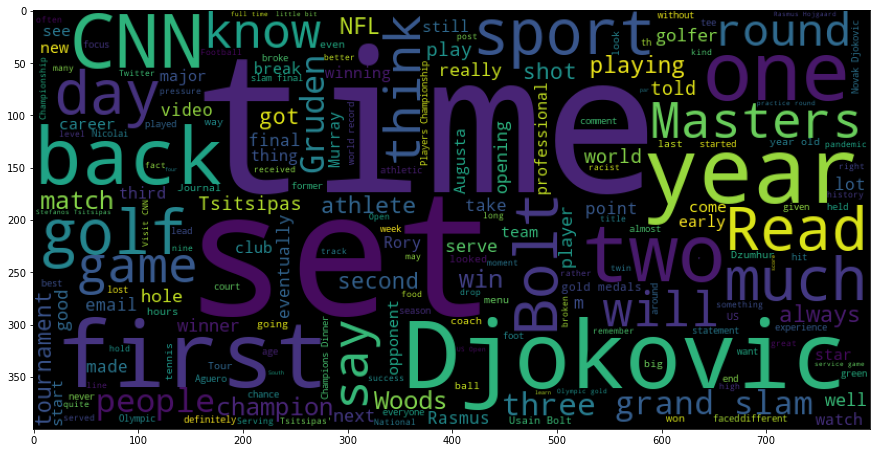

In [53]:
func("France vs Croatia Soccer World Cup 2018 Final?")